##  一、 讀入訓練好的模型

In [10]:
from tensorflow.keras.datasets import mnist
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential #Initialise our neural network model as a sequential network
from tensorflow.keras.layers import Conv2D #Convolution operation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation#Applies activation function
from tensorflow.keras.layers import Dropout#Prevents overfitting by randomly converting few outputs to zero
from tensorflow.keras.layers import MaxPooling2D # Maxpooling function
from tensorflow.keras.layers import Flatten # Converting 2D arrays into a 1D linear vector
from tensorflow.keras.layers import Dense # Regular fully connected neural network
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

### 讀入架構

In [2]:
import numpy as np  
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
with open("C:/Users/Owner/Desktop/face/Models/fer.json", "r") as text_file:
    json_string = text_file.read()
    model = Sequential()
    model = model_from_json(json_string)
    

In [4]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_14 (Batc (None, 23, 23, 128)      

### 讀入權重

In [5]:
model.load_weights('C:/Users/Owner/Desktop/face/Models/fer.h5')

In [8]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

### 讀入資料

In [11]:
data =pd.read_csv("C:/Users/Owner/Desktop/face/fer2013/fer2013.csv")

In [12]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [13]:
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprsie', 'Neutral']

In [14]:
for i in range(0,7,1):
    
    print(classes[i],len(data[data["emotion"]==i]))

Angry 4953
Disgust 547
Fear 5121
Happy 8989
Sad 6077
Surprsie 4002
Neutral 6198


### 分類資料較少的屬性及不明顯差異如disgust/surprised/neutral去除

In [15]:
data=data[~data['emotion'].isin([1])]
data=data[~data['emotion'].isin([5])]
data=data[~data['emotion'].isin([6])]

### 將資料的維度進行調整，以能夠作為CNN的輸入

In [16]:
width, height = 48, 48

datapoints = data['pixels'].tolist()

#getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)
#加一的 dim 是 讓 CNN 可以用 
#getting labels for training
y = pd.get_dummies(data['emotion']).as_matrix()

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: "+ str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")

Preprocessing Done
Number of Features: 48
Number of Labels: 4
Number of examples in dataset:25140
X,y stored in fdataX.npy and flabels.npy respectively


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


### 將資料標準化

In [17]:
num_features = 64
num_labels = 4
batch_size = 64

X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

### 分成train跟test data set

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

In [22]:
X_train.shape

(20363, 48, 48, 1)

In [21]:
X_test.shape

(2514, 48, 48, 1)

### 計算模型訓練結果

In [23]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2514/2514 [==============================] - 14s 5ms/sample - loss: 1.2992 - accuracy: 0.4121
Test loss: 1.2991865110852554
Test accuracy: 0.41209227


## 二、對合照進行臉部擷取

### 讀入opencv2套件

In [148]:
import cv2


face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
face_cascade.load('C:/Users/Owner/Desktop/face/haarcascade_frontalface_default.xml')

True

In [149]:
img = cv2.imread('test2.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [150]:
def convertToRGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

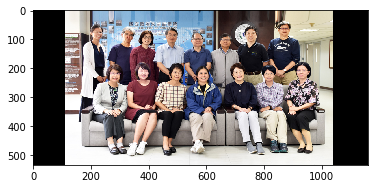

In [151]:
plt.imshow(convertToRGB(img))

### 進行臉部偵測

In [152]:
faces = face_cascade.detectMultiScale(gray, 1.5, 1)

In [153]:
len(faces)

15

### 共偵測到15張臉

In [154]:
test=[]
for (x, y, w, h) in faces:
    
    
    

    a = img[y:y+h,x:x+w]
    a = cv2.resize(a,(48,48),interpolation=cv2.INTER_CUBIC)
    a = cv2.cvtColor(a,cv2.COLOR_BGR2GRAY)


    test.append(a.astype('float32'))

In [155]:
test = np.asarray(test)

In [156]:
test.shape

(15, 48, 48)

In [157]:
test[0].shape

(48, 48)

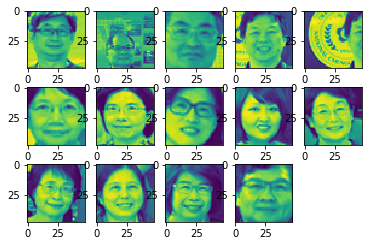

In [158]:
plt.figure()
for i in range(1,15,1):
    plt.subplot(3,5,i)
    plt.imshow(test[i-1])
plt.show()

In [159]:
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    a = img[y:y+h,x:x+w]

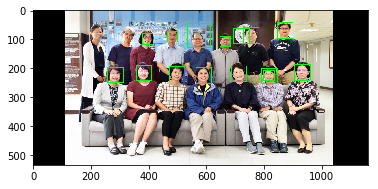

In [160]:
plt.imshow(convertToRGB(img))

In [161]:
test = np.expand_dims(test, -1)

In [162]:
test.shape

(15, 48, 48, 1)

In [163]:
test -= np.mean(test, axis=0)
test /= np.std(test, axis=0)

In [164]:
predict = model.predict_classes(test)

In [165]:
classes = ['Angry', 'Fear', 'Happy', 'Sad']

In [166]:
for i in range(0,len(predict),1):
    print(i+1," ",classes[predict[i]]
         )

1   Sad
2   Sad
3   Happy
4   Happy
5   Happy
6   Happy
7   Happy
8   Happy
9   Happy
10   Happy
11   Happy
12   Happy
13   Happy
14   Happy
15   Happy
